In [2]:
import matplotlib.pyplot as plt
import numpy as np
from rich import print as rprint
import pickle

In [84]:
# load data for imagenet
with open("../jobs/profiles/yolov3.pkl", "rb") as f:
    data = pickle.load(f)
rprint(f"Num profiles: {len(data['logs'])}")

Num profiles: 4889

In [85]:
# standardize plot
def standardize(plot, size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

In [86]:
# extrapolate data
def extrapolate(x, y, extra_x, degree=3):
  # fit a curve with degree
  params = np.polyfit(x, y, degree)
  # evaluate polynomial at extra_x
  return np.polyval(params, extra_x)

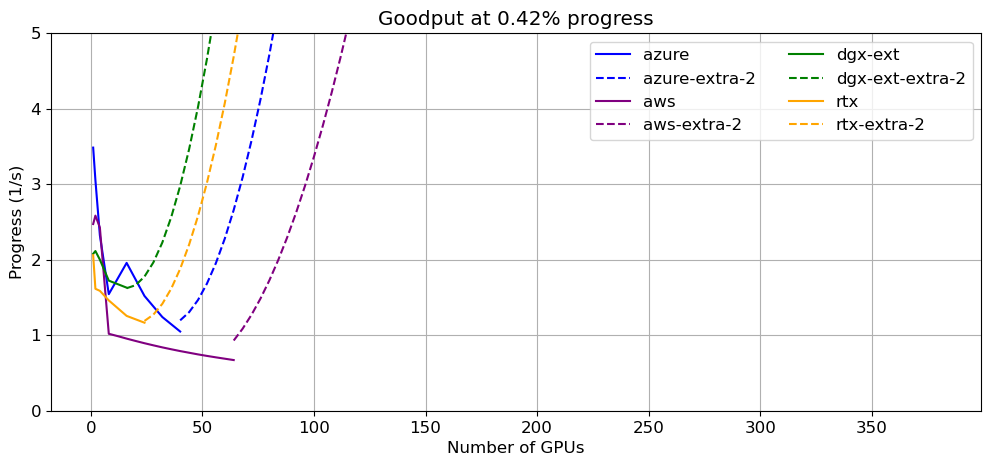

In [91]:
# plot data for an arbitrary index for all GPU types
configs = data["configs"]
logs = data["logs"]
config_ngpus = {gpu_type : configs[gpu_type]['num_gpus'] for gpu_type in configs.keys()}
idx = 20
extra_ngpus = [1, 2]
extra_ngpus.extend([4*i for i in range(1, 96)])
extra_ngpus = np.array(extra_ngpus)
extrapolate_poly_degree = 2
gpu_type_to_colors_map = {
    "azure": "blue",
    "quad": "red",
    "dgx-ext": "green",
    "rtx" : "orange",
    "aws" : "purple"
}

for gpu_type in configs.keys():
    if gpu_type == 'quad':
        continue
    color = gpu_type_to_colors_map[gpu_type]
    num_gpus = config_ngpus[gpu_type]
    goodput = logs[idx]['goodputs'][gpu_type]
    goodput = np.array(goodput)
    plt.plot(num_gpus, goodput, label=f"{gpu_type}", color=color)
    # extrapolate this curve
    extra_goodput = extrapolate(x=num_gpus, y=goodput, extra_x=extra_ngpus, degree=extrapolate_poly_degree)
    valid_plot_idxs = (extra_ngpus >= num_gpus[-1]) & (extra_goodput >= 0)
    plot_x, plot_y = extra_ngpus[valid_plot_idxs], extra_goodput[valid_plot_idxs]
    plt.plot(plot_x, plot_y, linestyle='--', label=f"{gpu_type}-extra-{extrapolate_poly_degree}", color=color)
plt.legend(loc='upper right', ncols=2)
progress_perc = logs[idx]['progress'] / logs[-1]['progress'] * 100
plt.title(f"Goodput at {progress_perc:.2f}% progress")
plt.xlabel("Number of GPUs")
plt.ylabel("Progress (1/s)")
plt.ylim(0, 5)
standardize(plt, size=(12, 5))

### Generate synthetic profiles ###

In [110]:
# basic one-phase job with sub-linear scaling
class SyntheticJob:
  def __init__(self, base_work_per_gpu, work_rate_per_gpu, work_attentuation_factor, \
               compute_time_system_overheads_factor, base_comm_per_gpu, work_comm_overlap_factor):
    self.base_work_per_gpu = base_work_per_gpu
    self.work_rate_per_gpu = work_rate_per_gpu
    self.work_attentuation_factor = work_attentuation_factor
    self.compute_time_system_overheads_factor = compute_time_system_overheads_factor
    self.base_comm_per_gpu = base_comm_per_gpu
    self.work_comm_overlap_factor = work_comm_overlap_factor
  
  def work(self, n):
    # ideal work scales linearly
    ideal_work = self.base_work_per_gpu * n
    # sub-linear scaling: useful work with n processors < n * useful work with 1 processor
    attenuation = (1 - self.work_attentuation_factor)**n
    return ideal_work * attenuation

  def compute_time(self, n):
    # ideal compute time scales linearly
    ideal_compute_time = self.work(n) / (n * self.work_rate_per_gpu)
    # filesystem, other contentions etc. increase compute time a bit
    system_overheads = (1 - self.compute_time_system_overheads_factor)**n
    return ideal_compute_time / system_overheads
  
  def comm_time(self, n):
    # ideal comm time scales logarithmically for tree-based all-reduce
    ideal_comm_time = self.base_comm_per_gpu
    scaling = np.log2(n)
    return ideal_comm_time * scaling
  
  def iter_time(self, n):
    # model overlap between compute and communication for DLT jobs
    compute_time = self.compute_time(n)
    comm_time = self.comm_time(n)
    return comm_time + compute_time * (1 - self.work_comm_overlap_factor)

  def goodput(self, n):
    # rate of useful work done per second = work done / iteration time
    work = self.work(n)
    iter_time = self.iter_time(n)
    return work / iter_time

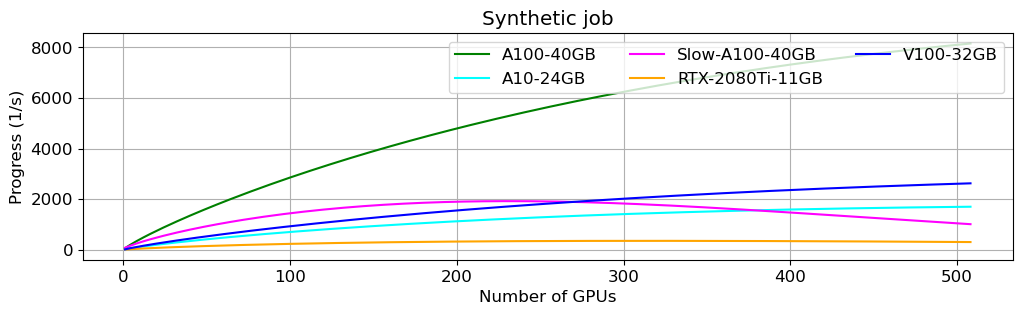

In [212]:
# sample job
a100_job = {'base_work_per_gpu': 200, 'work_rate_per_gpu': 40, 'work_attentuation_factor': 1e-3, 
            'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 0.5, 
            'work_comm_overlap_factor': 0.4}
a100_bad_job = {'base_work_per_gpu': 200, 'work_rate_per_gpu': 35, 'work_attentuation_factor': 1e-3, 
            'compute_time_system_overheads_factor': 7e-3, 'base_comm_per_gpu': 1.25, 
            'work_comm_overlap_factor': 0.6}
a10_job = {'base_work_per_gpu': 100, 'work_rate_per_gpu': 20, 'work_attentuation_factor': 1e-3, 
            'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 1.25, 
            'work_comm_overlap_factor': 0.2}
rtx_job = {'base_work_per_gpu': 60, 'work_rate_per_gpu': 13, 'work_attentuation_factor': 2e-3, 
            'compute_time_system_overheads_factor': 5e-3, 'base_comm_per_gpu': 2.5, 
            'work_comm_overlap_factor': 0.4}
v100_job = {'base_work_per_gpu': 120, 'work_rate_per_gpu': 17, 'work_attentuation_factor': 1e-3, 
            'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 1.0, 
            'work_comm_overlap_factor': 0.3}
a100_job_obj = SyntheticJob(**a100_job)
bad_a100_job_obj = SyntheticJob(**a100_bad_job)
a10_job_obj = SyntheticJob(**a10_job)
rtx_job_obj = SyntheticJob(**rtx_job)
v100_job_obj = SyntheticJob(**v100_job)
ngpus = [1, 2]
ngpus.extend([4*i for i in range(1, 128)])
ngpus = np.array(ngpus)
a100_goodput = [a100_job_obj.goodput(n) for n in ngpus]
bad_a100_goodput = [bad_a100_job_obj.goodput(n) for n in ngpus]
a10_goodput = [a10_job_obj.goodput(n) for n in ngpus]
rtx_goodput = [rtx_job_obj.goodput(n) for n in ngpus]
v100_goodput = [v100_job_obj.goodput(n) for n in ngpus]
plt.plot(ngpus, a100_goodput, label="A100-40GB", color="green")
plt.plot(ngpus, a10_goodput, label="A10-24GB", color="cyan")
plt.plot(ngpus, bad_a100_goodput, label="Slow-A100-40GB", color="magenta")
plt.plot(ngpus, rtx_goodput, label="RTX-2080Ti-11GB", color="orange")
plt.plot(ngpus, v100_goodput, label="V100-32GB", color="blue")
plt.legend(loc='upper right', ncols=3)
plt.title("Synthetic job")
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Number of GPUs")
plt.ylabel("Progress (1/s)")
standardize(plt, size=(12, 3))